# Experiment: Million Songs Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,RidgeCV
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
import seaborn as sns

import torch
from torch.utils.data import Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

df=pd.read_csv('YearPredictionMSD.txt',header=None,sep = ',')
#smaller dataset
train=df.iloc[300000:300700] 
test=df.iloc[500000:500300] 

train_y = train[0]
test_y = test[0] #response:year
train_x = train
test_x = test
del train_x[0]
del test_x[0]
total_x=pd.concat([train_x,test_x])
x=preprocessing.StandardScaler().fit(total_x).transform(total_x) #normalize
x=pd.DataFrame(x)
train_x=x.iloc[:700]
test_x=x.iloc[700:]

train_x.reset_index(drop=True, inplace=True) 
test_x.reset_index(drop=True, inplace=True) 
train_y.reset_index(drop=True, inplace=True) 
test_y.reset_index(drop=True, inplace=True) 

train_x ##display the data

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,-1.169588,-0.913331,-1.303357,0.366642,-1.446675,-0.408470,0.866105,0.914454,-1.242843,-0.667838,...,0.207254,0.352000,-1.993373,-0.121706,-0.624721,-3.186580,2.233731,-1.497663,1.015620,1.535324
1,-0.384652,0.083956,-0.409324,0.340569,-0.922879,0.015633,1.158662,0.921513,0.571624,0.059751,...,2.548116,1.116907,-0.863423,-1.574714,1.571018,0.933343,-0.660936,0.018256,-0.441595,0.061384
2,-0.474117,1.071657,-2.011545,1.578102,-0.387551,0.668625,1.009691,-1.046157,0.164916,0.055518,...,-0.107606,-4.416389,6.454818,3.133579,4.412800,-6.273857,-2.294102,6.551096,-0.142954,-0.990494
3,-1.085627,1.033851,-1.001179,2.001694,0.231899,1.523338,1.051318,1.507985,-0.941449,-0.231110,...,0.101883,3.043570,1.424674,-1.320191,1.222839,0.278665,2.211740,0.589111,-2.269302,1.055646
4,-0.705294,-0.778753,-2.057925,-0.842471,0.976928,-0.353554,-0.405709,0.509083,0.569620,-0.519164,...,-1.579429,0.847409,-1.423293,0.122463,-0.858162,-1.384214,0.440914,-1.079154,-0.234252,0.420268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,-1.448799,0.325952,0.582353,0.258919,0.149646,-0.474193,-1.217127,-0.916761,0.088114,-0.320500,...,0.175976,-0.362254,-1.443022,-0.329998,-0.809020,-0.096618,-1.097373,1.158430,-0.030136,-0.139725
696,-0.743319,0.679493,-0.121131,0.266191,0.153593,0.116883,0.285190,0.262373,0.744065,1.012218,...,0.336759,-0.120216,-0.228381,-0.525685,0.470486,-0.179525,-0.485096,-0.265838,-0.166360,-0.097013
697,-1.079830,0.074670,-0.605215,-0.890968,0.940719,-0.745934,-2.093624,-0.008216,1.374812,1.199631,...,0.253918,0.084684,-0.654068,-0.514407,-0.104413,0.146940,-0.811716,0.178947,0.876225,0.210794
698,-0.628019,0.188730,0.035737,-0.332677,0.625774,-0.682705,0.116143,-0.111752,1.780001,0.683753,...,1.043273,0.018961,-0.808076,0.129063,-0.854428,0.051633,0.294883,0.436294,-0.226600,2.013739


In [2]:
nntrain_x = torch.from_numpy(train_x.to_numpy()).float()
nntrain_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float()) 
nntest_x= torch.from_numpy(test_x.to_numpy()).float()
nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len

## 1. DNN

In [3]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(90, 32)
        self.fc2 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, 1)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net()
net = net.to(device)
torch.manual_seed(0)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-6,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
dnn_trainloss=[]
dnn_testloss=[]
t0=time.time()
for epoch in range(2000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()

    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)
    
        test_loss = criterion(y_test_pred,y)
    
    if epoch>100 and float(test_loss)>max(dnn_testloss[-100:-1]):
        break
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    
    dnn_trainloss.append(float(train_loss))
    dnn_testloss.append(float(test_loss))
            
dnn_fit = time.time() - t0
print("DNN complexity and model fitted in %.3f s" % dnn_fit)

Net(
  (fc1): Linear(in_features=90, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 3984438.0
            Test  set - loss: 4001260.5
            
epoch 100
            Train set - loss: 399.58258056640625
            Test  set - loss: 2541.88427734375
            
epoch 200
            Train set - loss: 151.03475952148438
            Test  set - loss: 915.9685668945312
            
epoch 300
            Train set - loss: 84.96205139160156
            Test  set - loss: 690.5421752929688
            
epoch 400
            Train set - loss: 58.495849609375
            Test  set - loss: 630.4786987304688
            
epoch 500
            Train set - loss: 59.73417663574219
            Test  set - loss: 593.3506469726562
            
epoch 600
            Train set - loss: 48.43214416503906
            Test  set - loss: 594.4166870117188
            
ep

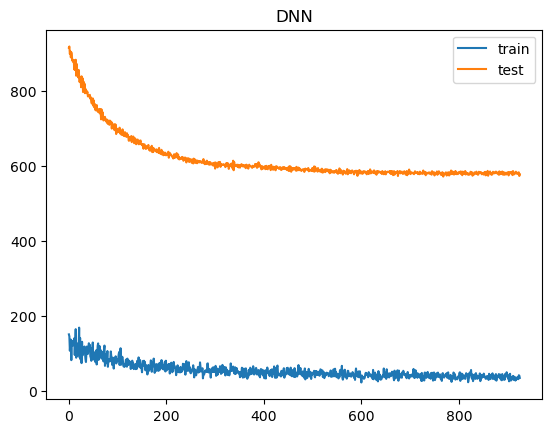

In [4]:
plt.plot(dnn_trainloss[200:])
plt.plot(dnn_testloss[200:])
plt.legend(['train','test'])
plt.title('DNN')
plt.show()

In [5]:
#predict
x0=torch.from_numpy(test_x[:300].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    print(np.array(pred).reshape(-1))
    print(test_y[:300].to_numpy())
    bootbase=np.array(pred.reshape(-1))

[2009.8662 1995.0034 1995.8103 1993.2722 1967.9526 1995.616  1993.1023
 1984.5717 1956.053  2052.538  1998.8594 1996.1492 2007.8044 2094.8936
 1996.214  1998.3212 2023.0339 2007.9916 1996.6873 2006.2012 1992.9655
 2008.447  2003.084  2006.6176 2005.1211 1998.6244 1981.2644 1990.3889
 1988.553  1996.0564 1996.4429 1996.379  2000.3834 2000.4506 1990.8502
 1991.5233 2005.4056 1986.5293 1993.7524 1994.9631 2021.8197 1974.8461
 1985.6997 1996.3734 1986.5724 2138.2334 1967.6622 2008.169  2167.4866
 1949.4005 1975.5488 1930.982  2004.7349 2008.4417 2028.6278 2036.2114
 2010.0999 2016.37   2001.7365 2001.4053 2002.6829 1998.3738 2006.5432
 2004.5957 1998.7206 2001.4896 2004.5957 2002.9324 2006.0273 1963.497
 2013.3618 1960.0719 1977.1788 1973.7478 1971.0902 1973.0684 2063.8765
 2059.8442 2046.7124 2157.7136 2078.3716 1982.5956 2017.4602 1976.3568
 1978.8015 1991.0945 2047.4651 2023.1187 1992.7375 1979.336  2054.2236
 2002.4612 1983.9093 1998.103  1990.9263 1996.8903 2010.292  1995.9662
 1996.7

In [5]:
#bootstrap  
boottime=80
bootlist=[]
for boot in tqdm(range(boottime)):
    alltrain=pd.concat([train_y,train_x],axis=1) 
    datachoose=resample(alltrain,replace=True)
    bootstrap_y=datachoose.iloc[:,0]
    bootstrap_x=datachoose.iloc[:,1:]
    bootstrap_x.reset_index(drop=True, inplace=True) 
    bootstrap_y.reset_index(drop=True, inplace=True) 
    nnbootstrap_x = torch.from_numpy(bootstrap_x.to_numpy()).float()
    nnbootstrap_y = torch.squeeze(torch.from_numpy(bootstrap_y.to_numpy()).float()) 
    nntest_x= torch.from_numpy(test_x.to_numpy()).float()
    nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())
    
    train_loader = DataLoader(mydataset(nnbootstrap_x, nnbootstrap_y),batch_size=100, shuffle=True)
    test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = Net()
    net = net.to(device)
    torch.manual_seed(0)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=1e-6,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
    dnn_testloss=[]
    t0=time.time()
    for epoch in range(2000): 
        for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
            x, y = x.to(device), y.to(device)
            # Compute prediction error
            y_pred = net(x)
            y_pred = torch.squeeze(y_pred)
            train_loss = criterion(y_pred, y)
            # Backpropagation
            optimizer.zero_grad() 
            train_loss.backward()
            optimizer.step()

        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
        
            test_loss = criterion(y_test_pred,y)
        
        if epoch>100 and float(test_loss)>max(dnn_testloss[-100:-1]):
            break
        dnn_testloss.append(float(test_loss))
    
    x0=torch.from_numpy(test_x[:300].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        bootlist.append(np.array(pred).reshape(-1))

100%|██████████| 80/80 [27:22<00:00, 20.54s/it]


In [6]:
np.array(bootlist).T
sorted_bootlist = [sorted(x)[:] for x in np.array(bootlist).T]
sorted_bootlist=np.array(sorted_bootlist)

lower=bootbase-(sorted_bootlist[:,77]-bootbase)
upper=bootbase-(sorted_bootlist[:,2]-bootbase)
print("confidence interval length",sorted_bootlist[:,77]-sorted_bootlist[:,2])
dnn_length=(sorted_bootlist[:,77]-sorted_bootlist[:,2]).mean()
print("average confidence interval length",dnn_length)

cover=0
for i in range(300):
    if lower[i]<=test_y[i] and upper[i]>=test_y[i]:
        cover=cover+1
dnn_coverage=cover/300
print("95 coverage",dnn_coverage)

confidence interval length [ 67.00256   60.99182   45.463013 105.73218  187.40955   40.641357
  49.288086  60.26367  222.00671  132.18457   47.295288  99.760376
  98.47058  355.99426   76.5459    39.533203 127.91785   37.11438
  28.20105   42.63977  216.18689   65.93042  163.328     47.145508
  40.878784  67.40332   23.32727   34.037354  35.56311   60.11084
  56.902832  47.33789   22.056519  25.358276  31.638916  31.018066
  29.340332  45.236572  49.982178  41.777588 105.631714 149.1908
  81.800415 357.7124   293.4297   400.0465   154.99194  182.0747
 305.37256  281.00854  234.62744  189.51526   91.23901   96.84241
  74.44055  180.68811   95.53381   97.27893  114.309204 197.25256
 200.66138  192.4364   207.84229  203.75916   74.39722   92.829834
 203.75916  127.317505 210.44397   94.66382  133.7533   115.42554
 158.93555   69.823     79.24939   80.24817  365.03394  344.56897
 265.16003  655.33594  284.73877  186.48438  143.53125   67.03088
  68.9541   204.08472  335.02747   64.10181   

## 2. Resnet

In [6]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(infeatures,outfeatures)
    
    def forward(self, x):
        y = self.fc1(x)
        y= F.relu(y)
        x = self.fc2(x)
        return F.relu(x+y)


class ResNet(nn.Module): 
    def __init__(self):
        super(ResNet, self).__init__()
        self.rblock1 = ResidualBlock(90,32)
        self.rblock2 = ResidualBlock(32,8)
        self.fc3 = nn.Linear(8,1)
    
 
    def forward(self, x):
        x = self.rblock1(x)
        x = self.rblock2(x)
        return self.fc3(x)
#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResNet()
net = net.to(device)
torch.manual_seed(0)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-7,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
res_trainloss=[]
res_testloss=[]
t0=time.time()
for epoch in range(4000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()

    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)
    
        test_loss = criterion(y_test_pred,y)
    
    if epoch>100 and float(test_loss)>max(res_testloss[-100:-1]):
        break
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    res_trainloss.append(float(train_loss))
    res_testloss.append(float(test_loss))
            
dnn_fit = time.time() - t0
print("ResNet complexity and model fitted in %.3f s" % dnn_fit)

ResNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=90, out_features=32, bias=True)
    (fc2): Linear(in_features=90, out_features=32, bias=True)
  )
  (rblock2): ResidualBlock(
    (fc1): Linear(in_features=32, out_features=8, bias=True)
    (fc2): Linear(in_features=32, out_features=8, bias=True)
  )
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 3977215.0
            Test  set - loss: 4000395.25
            
epoch 100
            Train set - loss: 3124.539794921875
            Test  set - loss: 11475.6611328125
            
epoch 200
            Train set - loss: 886.2252197265625
            Test  set - loss: 4481.39892578125
            
epoch 300
            Train set - loss: 388.1315612792969
            Test  set - loss: 2702.1875
            
epoch 400
            Train set - loss: 172.0522918701172
            Test  set - loss: 2024.3753662109375
            
epoch 500
            Train set - loss: 175.758941650

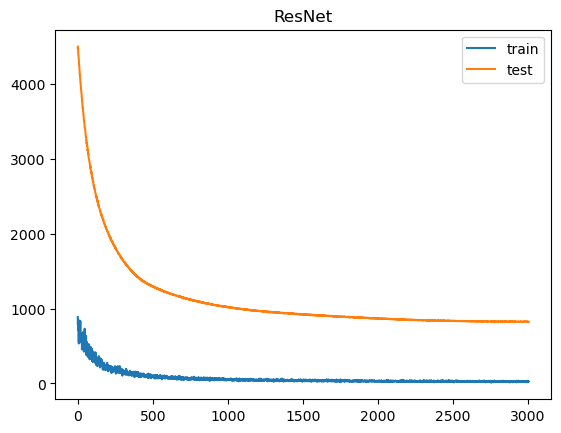

In [7]:
plt.plot(res_trainloss[200:])
plt.plot(res_testloss[200:])
plt.legend(['train','test'])
plt.title('ResNet')
plt.show()

In [8]:
#predict
x0=torch.from_numpy(test_x[:300].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    print(np.array(pred).reshape(-1))
    print(test_y[:300].to_numpy())
    bootbase=np.array(pred.reshape(-1))

[2036.0021 1979.0992 1982.1678 1992.9504 2033.2422 1990.5587 1991.5238
 1993.0455 1956.7035 2024.8884 1993.752  1971.9182 1984.7587 2086.38
 1968.6139 1988.6139 1986.6417 1998.078  1986.9368 2000.8453 2033.6958
 2011.2865 2006.9769 2001.4838 2003.9198 2010.8566 1982.2084 1988.6368
 1985.7222 1989.421  1977.5104 2000.0085 1997.0186 1998.6189 1985.6687
 1983.4315 1995.4008 1979.2738 1991.8075 1994.5906 2008.23   1972.63
 1986.6146 2040.8832 2007.1626 2092.922  1976.346  2047.3496 2215.3137
 1954.6752 1992.9725 1988.4978 2024.0548 1996.4207 2029.138  2004.4126
 1968.8516 2069.4358 1979.4874 2065.613  2066.519  2061.6912 2070.9036
 2069.4202 1995.1963 2047.2445 2069.4202 2065.765  2072.5208 1975.1646
 1975.4065 1961.1183 1969.0084 1966.1976 1963.385  1956.0413 2101.5544
 2043.2462 2033.6702 2086.1375 1997.1833 1979.5021 1989.474  1959.811
 1986.4248 2000.9965 1964.7544 1995.0864 2003.7578 1989.6285 2013.7294
 2014.4161 1968.5372 2005.7827 1982.3655 1992.0304 2042.7592 1984.8749
 1987.1105 

In [312]:
#bootstrap  
boottime=80
bootlist=[]
for boot in tqdm(range(boottime)):
    alltrain=pd.concat([train_y,train_x],axis=1) 
    datachoose=resample(alltrain,replace=True)
    bootstrap_y=datachoose.iloc[:,0]
    bootstrap_x=datachoose.iloc[:,1:]
    bootstrap_x.reset_index(drop=True, inplace=True) 
    bootstrap_y.reset_index(drop=True, inplace=True) 
    nnbootstrap_x = torch.from_numpy(bootstrap_x.to_numpy()).float()
    nnbootstrap_y = torch.squeeze(torch.from_numpy(bootstrap_y.to_numpy()).float()) 
    nntest_x= torch.from_numpy(test_x.to_numpy()).float()
    nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())
    
    train_loader = DataLoader(mydataset(nnbootstrap_x, nnbootstrap_y),batch_size=100, shuffle=True)
    test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = ResNet()
    net = net.to(device)
    torch.manual_seed(0)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=1e-7,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
    res_testloss=[]
    t0=time.time()
    for epoch in range(4000):  
        for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
            x, y = x.to(device), y.to(device)
            # Compute prediction error
            y_pred = net(x)
            y_pred = torch.squeeze(y_pred)
            train_loss = criterion(y_pred, y)
            # Backpropagation
            optimizer.zero_grad() 
            train_loss.backward()
            optimizer.step()

        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
        
            test_loss = criterion(y_test_pred,y)
        
        if epoch>100 and float(test_loss)>max(res_testloss[-100:-1]):
            break
        res_testloss.append(float(test_loss))
            
    x0=torch.from_numpy(test_x[:300].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        bootlist.append(np.array(pred).reshape(-1))

100%|██████████| 80/80 [1:16:25<00:00, 57.32s/it]


In [313]:
np.array(bootlist).T
sorted_bootlist = [sorted(x)[:] for x in np.array(bootlist).T]
sorted_bootlist=np.array(sorted_bootlist)

lower=bootbase-(sorted_bootlist[:,77]-bootbase)
upper=bootbase-(sorted_bootlist[:,2]-bootbase)
print("confidence interval length",sorted_bootlist[:,77]-sorted_bootlist[:,2])
resnet_length=(sorted_bootlist[:,77]-sorted_bootlist[:,2]).mean()
print("average confidence interval length",resnet_length)

cover=0
for i in range(300):
    if lower[i]<=test_y[i] and upper[i]>=test_y[i]:
        cover=cover+1
resnet_coverage=cover/300
print("95 coverage",resnet_coverage)

confidence interval length [ 91.24475   82.83154   62.97766  108.848145 163.98572   48.860596
  68.57422   91.62158  146.61694  112.02893   55.386963 107.578
  75.56201  380.45837   81.66504   48.884644  94.85303   41.63501
  38.731934  43.496094 188.48608   75.74841  118.720215  67.242676
  60.298462  74.36316   36.021484  25.378662  42.623413  58.584473
  67.74158   62.881104  27.970947  33.586304  34.0094    46.95337
  43.57373   51.59497   58.186157  37.975586 116.232666 111.09387
 134.71399  428.6919   284.81836  340.1172   162.17908  179.57434
 287.3108   383.43884  216.92896  148.6305   101.88306   81.632324
  82.28577  155.66199   69.056274 137.0426   124.19299  220.83386
 220.65063  223.29517  222.2843   221.5863    82.84924   85.65674
 221.5863   118.88269  219.82373   98.74072  142.6106   132.35693
 110.49182   59.833984  88.326904 100.46936  346.6443   292.86682
 285.05896  594.76196  261.93677  181.11841  143.61084   70.95911
  70.32837  158.66638  260.6626    60.321777  5

## Random Feature

definition of random feature

In [9]:
def sample_1d(pdf, gamma):
    if pdf=='G':
        w=np.random.randn(1)*gamma
        return w
    elif pdf=='L':
        w=np.random.laplace(1)*gamma
        return w
    elif pdf=='C':
        w=np.random.standard_cauchy(1)*gamma
        return w
    

def sample(pdf, gamma, d):
    return [sample_1d(pdf, gamma) for _ in range(d)]


class RandomFourierFeature:
    """Random Fourier Feature
    Parameters
    ----------
    d : int
        Input space dimension
    D : int
        Feature space dimension
    W : np.array
        shape (D,d)
    b : np.array
        shape (D)
    kernel : char
        Kernel to use; 'G', 'L', or 'C'
    gamma : float
        pdf parameter
    """

    def __init__(self, d, D, W=None, b=None, kernel='G', gamma=1):

        self.d = d
        self.D = D
        self.gamma = gamma

        kernel = kernel.upper()
        if kernel not in ['G', 'L', 'C']:
            raise Exception('Invalid Kernel')
        self.kernel = kernel

        if W is None or b is None:
            self.create()
        else:
            self.__load(W, b)

    def __load(self, W, b):
        """Load from existing Arrays"""

        self.W = W.reshape([self.D, self.d])
        self.b = b
    

    def create(self):
        """Create a d->D fourier random feature"""

        self.b = np.random.uniform(0, 2 * np.pi, self.D)
        self.W = np.reshape(
            np.array([
                sample(self.kernel, self.gamma, self.d)
                for _ in range(self.D)], dtype=np.float32),
            (self.D, self.d))

    def transform(self, x):
        """Transform a vector using this feature
        Parameters
        ----------
        x : np.array (shape=(n,d))
            Array to transform; must be single dimension vector
        Returns
        -------
        x : np.array (shape=(n,D))
            Feature space transformation of x
        """
        x=pd.DataFrame(x)
        result=np.array([
            np.sqrt(2 / self.D) * np.cos(np.dot(self.W, x.iloc[i]) + self.b) for i in range(len(x))]
            )            
        return result

Linear regression vs single layer random feature model

In [41]:
model =LinearRegression()
model.fit(train_x, train_y)
y_pretest=model.predict(test_x)
y_pretrain=model.predict(train_x)
print("Linear Ridge train mse:",mean_squared_error(train_y,y_pretrain))
print("test mse:",mean_squared_error(test_y,y_pretest))

score=[]
trainmse=[]
testmse=[]
gaset=np.linspace(0.1,0.5,100)
for ga in gaset:
    rff=RandomFourierFeature(90,30,kernel='G',gamma=ga)
    total_x=pd.concat([train_x,test_x])
    feature=rff.transform(total_x)
    train_xtransformed=feature[:len(train_x)]
    test_xtransformed=feature[len(train_x):]
    model.fit(train_xtransformed, train_y)
    y_pretest=model.predict(test_xtransformed)
    y_pretrain=model.predict(train_xtransformed)
    score.append(cross_val_score(model,train_xtransformed,train_y,cv=5).mean())   ##cross-validation
    trainmse.append(mean_squared_error(y_pretrain,train_y))
    testmse.append(mean_squared_error(y_pretest,test_y))
ind=score.index(max(score))
print("cv-score,index,gamma,trainmse,testmse",max(score),ind,gaset[ind],trainmse[ind],testmse[ind])

Linear Ridge train mse: 74.86242454318058
test mse: 154.0442425294812
cv-score,index,gamma,trainmse,testmse -0.838938290207604 4 0.11616161616161616 104.05082633330724 162.40226684422484


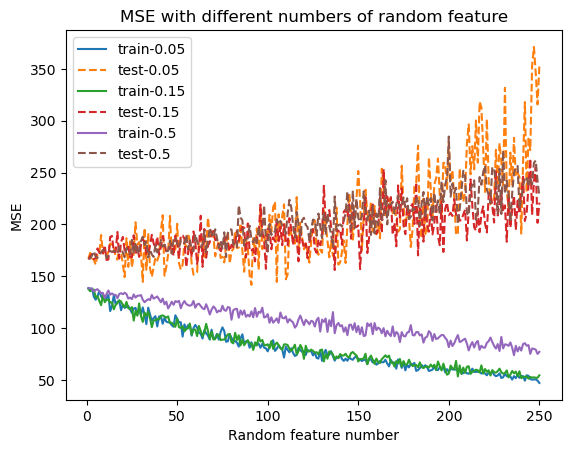

In [43]:
model =LinearRegression() #without bagging
Layer=1
m0set=np.linspace(1,250,250)
m0set=m0set.astype(int)
gaset=[0.05,0.15,0.5]

for ga in gaset:
    trainmse=[]
    testmse=[]
    t=[]
    for m0 in m0set:  
        rff=RandomFourierFeature(90,m0,kernel='G',gamma=ga)
        total_x=pd.concat([train_x,test_x])
        feature=rff.transform(total_x)
        train_xtransformed=feature[:700]
        test_xtransformed=feature[700:]
            
        model.fit(train_xtransformed, train_y)
        y_pretest=model.predict(test_xtransformed)
        y_pretrain=model.predict(train_xtransformed)
        
        trainmse.append(mean_squared_error(train_y,y_pretrain))
        testmse.append(mean_squared_error(test_y,y_pretest))

    plt.plot(m0set,trainmse)
    plt.plot(m0set,testmse,linestyle='dashed')
    

plt.xlabel("Random feature number")
plt.ylabel("MSE")
plt.title("MSE with different numbers of random feature")
plt.legend(["train-0.05","test-0.05","train-0.15","test-0.15","train-0.5","test-0.5"])
plt.show()

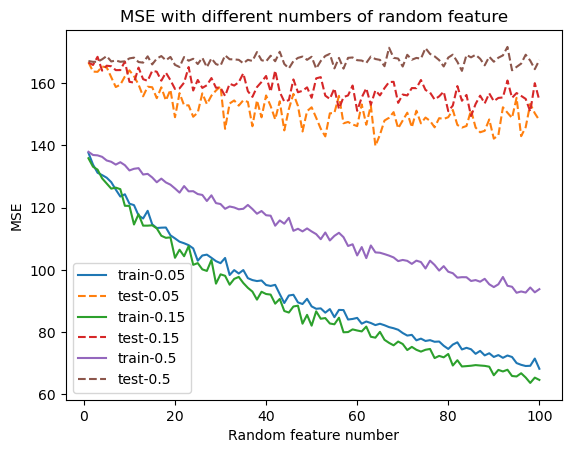

In [44]:
model =LinearRegression() #bagging
Layer=1
m0set=np.linspace(1,100,100)
m0set=m0set.astype(int)
gaset=[0.05,0.15,0.5]
n0=16

for ga in gaset:
    trainmse=[]
    testmse=[]
    t=[]
    for m0 in m0set:  
        for i in range(n0):
            rff=RandomFourierFeature(90,m0,kernel='G',gamma=ga)
            total_x=pd.concat([train_x,test_x])
            feature=rff.transform(total_x)
            train_xtransformed=feature[:700]
            test_xtransformed=feature[700:]
            
            model.fit(train_xtransformed, train_y)
            if i==0:
                y_pretest=model.predict(test_xtransformed)
                y_pretrain=model.predict(train_xtransformed)
            else:
                y_pretest=y_pretest+model.predict(test_xtransformed)
                y_pretrain=y_pretrain+model.predict(train_xtransformed) 
        
        y_pretest=y_pretest/n0
        y_pretrain=y_pretrain/n0
        
        trainmse.append(mean_squared_error(train_y,y_pretrain))
        testmse.append(mean_squared_error(test_y,y_pretest))

    plt.plot(m0set,trainmse)
    plt.plot(m0set,testmse,linestyle='dashed')
    

plt.xlabel("Random feature number")
plt.ylabel("MSE")
plt.title("MSE with different numbers of random feature")
plt.legend(["train-0.05","test-0.05","train-0.15","test-0.15","train-0.5","test-0.5"])
plt.show()

In [ ]:
model =Ridge(alpha=1)
model.fit(train_x, train_y)
y_pretest=model.predict(test_x)
y_pretrain=model.predict(train_x)
print("Linear Ridge train mse:",mean_squared_error(train_y,y_pretrain))
print("test mse:",mean_squared_error(test_y,y_pretest))

score=[]
trainmse=[]
testmse=[]
gaset=np.linspace(0,0.3,100)
for ga in gaset:
    rff=RandomFourierFeature(90,2000,kernel='G',gamma=ga)
    total_x=pd.concat([train_x,test_x])
    feature=rff.transform(total_x)
    train_xtransformed=feature[:len(train_x)]
    test_xtransformed=feature[len(train_x):]
    model.fit(train_xtransformed, train_y)
    y_pretest=model.predict(test_xtransformed)
    y_pretrain=model.predict(train_xtransformed)
    score.append(cross_val_score(model,train_xtransformed,train_y,cv=5).mean())   ##cross-validation
    trainmse.append(mean_squared_error(y_pretrain,train_y))
    testmse.append(mean_squared_error(y_pretest,test_y))
ind=score.index(max(score))
print("cv-score,index,gamma,trainmse,testmse",max(score),ind,gaset[ind],trainmse[ind],testmse[ind])

Linear Ridge train mse: 74.86409656538211
test mse: 153.7107056787628
cv-score,index,gamma,trainmse,testmse -0.4808480141674825 46 0.1393939393939394 46.73350973569064 152.42049196114354


one single gaussian kernel machine

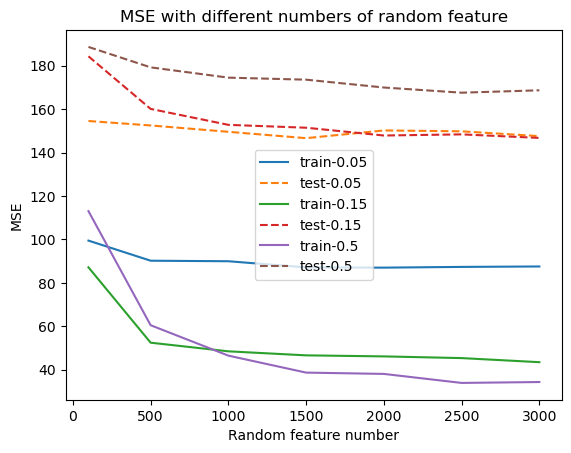

In [12]:
model=Ridge(alpha=1)
Layer=1
m0set=[100,500,1000,1500,2000,2500,3000]
gaset=[0.05,0.15,0.5]

for ga in gaset:
    trainmse=[]
    testmse=[]
    t=[]
    for m0 in m0set:  
        rff=RandomFourierFeature(90,m0,kernel='G',gamma=ga)
        total_x=pd.concat([train_x,test_x])
        feature=rff.transform(total_x)
        train_xtransformed=feature[:700]
        test_xtransformed=feature[700:]
            
        model.fit(train_xtransformed, train_y)
        y_pretest=model.predict(test_xtransformed)
        y_pretrain=model.predict(train_xtransformed)
        
        trainmse.append(mean_squared_error(train_y,y_pretrain))
        testmse.append(mean_squared_error(test_y,y_pretest))

    plt.plot(m0set,trainmse)
    plt.plot(m0set,testmse,linestyle='dashed')
    

plt.xlabel("Random feature number")
plt.ylabel("MSE")
plt.title("MSE with different numbers of random feature")
plt.legend(["train-0.05","test-0.05","train-0.15","test-0.15","train-0.5","test-0.5"])
plt.show()

# 3. new

In [10]:
def sample_1d(pdf, gamma):
    if pdf=='G':
        w=torch.randn(1)*gamma
        return w
    elif pdf=='L':
        w=torch.distributions.laplace.Laplace(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    elif pdf=='C':
        w=torch.distributions.cauchy.Cauchy(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    
def sample(pdf, gamma, d):
    return torch.tensor([sample_1d(pdf, gamma) for _ in range(d)])

class RandomFourierFeature:
    """Random Fourier Feature
    Parameters
    ----------
    d : int
        Input space dimension
    D : int
        Feature space dimension
    W : shape (D,d)
    b : shape (D)
    kernel : char
        Kernel to use; 'G', 'L', or 'C'
    gamma : float
        pdf parameter
    """

    def __init__(self, d, D, W=None, b=None, kernel='G', gamma=1):

        self.d = d
        self.D = D
        self.gamma = gamma

        kernel = kernel.upper()
        if kernel not in ['G', 'L', 'C']:
            raise Exception('Invalid Kernel')
        self.kernel = kernel

        if W is None or b is None:
            self.create()
        else:
            self.__load(W, b)

    def __load(self, W, b):
        """Load from existing Arrays"""

        self.W = W.reshape([self.D, self.d])
        self.b = b
    

    def create(self):
        """Create a d->D fourier random feature"""

        self.b = torch.rand(self.D)*2*torch.pi
        self.W = sample(self.kernel, self.gamma, self.d*self.D).reshape(self.D,self.d)

    def transform(self, x):
        """Transform a vector using this feature
        Parameters
        ----------
        x : (shape=(n,d))
            to transform; must be single dimension vector
        Returns
        -------
        x : (shape=(n,D))
            Feature space transformation of x
        """
        #print(self.W.shape,self.b.reshape(-1,1).shape,x.shape)
        #print((self.W @ x.T).shape)
       
        result=torch.sqrt(torch.tensor([2.0/self.D])) * torch.cos( self.W @ x.T  + (self.b.reshape(-1,1) @ torch.ones(len(x)).reshape(1,-1))) 
        #print(result.T.shape)
        return result.T

In [116]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

rff1=RandomFourierFeature(90,32,kernel='C',gamma=0.01)
rff2=RandomFourierFeature(8,8,kernel='G',gamma=0.1)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(32, 8)
        self.fc2 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = rff1.transform(x)
        x=self.fc1(x)
        x = rff2.transform(x)
        return self.fc2(x)


#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = KernelNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=8e-4,momentum=0.9,weight_decay=1e-4) #optim.Adam(...)

loss=[]
kernelnn_trainloss=[]
kernelnn_testloss=[]
t0 = time.time()
for epoch in range(2000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)

        test_loss = criterion(y_test_pred,y)
            
    if epoch>100 and float(test_loss)>max(kernelnn_testloss[-100:-1]):
        break
    
    
    if epoch % 100 == 0:         
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
   
    kernelnn_trainloss.append(float(train_loss))
    kernelnn_testloss.append(float(test_loss))
        
    
dnn_fit = time.time() - t0
print("KernelNet complexity and model fitted in %.3f s" % dnn_fit)

KernelNet(
  (fc1): Linear(in_features=32, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 3700816.0
            Test  set - loss: 3479444.5
            
epoch 100
            Train set - loss: 756.2725219726562
            Test  set - loss: 2349.14599609375
            
epoch 200
            Train set - loss: 343.6078796386719
            Test  set - loss: 942.915771484375
            
epoch 300
            Train set - loss: 178.2222900390625
            Test  set - loss: 466.0467529296875
            
epoch 400
            Train set - loss: 141.15371704101562
            Test  set - loss: 277.6446838378906
            
epoch 500
            Train set - loss: 108.95800018310547
            Test  set - loss: 197.44728088378906
            
epoch 600
            Train set - loss: 118.76385498046875
            Test  set - loss: 162.07431030273438
            
epoch 700
            Train set - loss: 136.09207153

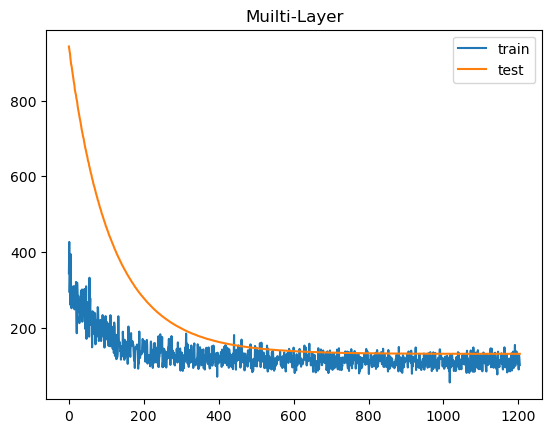

In [117]:
plt.plot(kernelnn_trainloss[200:])
plt.plot(kernelnn_testloss[200:])
plt.legend(['train','test'])
plt.title('Muilti-Layer')
plt.show()

In [118]:
#predict
x0=torch.from_numpy(test_x[:300].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    print(np.array(pred).reshape(-1))
    print(test_y[:300].to_numpy())
    bootbase=np.array(pred.reshape(-1))

[2002.2659 1990.4673 2009.1512 1992.5624 2005.0673 1991.9583 1996.677
 1990.7169 2011.0306 1988.8168 2005.6344 1989.4332 1981.1259 1996.9156
 1989.4817 2002.859  1986.9938 1993.522  2009.6249 1981.8383 1993.4097
 1993.0245 1993.9008 1985.3208 1995.755  1994.4958 1996.9419 2003.8866
 2002.7705 2003.9597 1997.9076 1999.6549 1996.1382 1997.0498 1996.1844
 2009.2167 1997.4111 1994.4757 1994.7605 1981.3329 1999.9451 2006.6879
 2012.0162 2007.7888 1989.3042 1986.3633 1991.6782 1993.3962 2003.4635
 1994.282  1993.8387 1997.3479 1991.692  1992.2141 1994.0752 2000.2454
 1989.3362 1990.5919 1999.166  2000.9203 2000.5436 1997.4701 2006.466
 2006.8712 1998.3557 1995.1692 2006.8712 1990.74   1998.2384 1989.0393
 1984.6815 1995.3367 2001.2723 1977.5485 1989.839  1999.9032 2002.6165
 1981.3425 1988.5243 2007.67   1997.2002 1993.3617 2001.1086 1979.9215
 1995.768  1994.598  1986.275  1992.6293 2000.9774 1984.3948 2001.7239
 1998.2211 1991.7861 1988.6295 1998.2832 1993.8782 1996.7085 1996.9647
 1997.09

In [119]:
#predict
par=optimizer.param_groups[0]['params']

for i in range(len(train_x)):
    x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
print(Fi.shape)

temp=torch.linalg.inv(Fi.T @ Fi)

length=[]
coverage=0
mark=0
for i in range(len(test_x)):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    #print(pred.detach().numpy()[0][0],test_y[i])
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    #print(2*1.96*np.sqrt(float(fFFf+1))) #approximate with df(infinity)
    
    if fFFf < 0:
        continue
    mark=mark+1
    length.append(2*1.96*np.sqrt(float(fFFf+1)))
    
    #coverage
    if pred.detach().numpy()[0][0]-1.96*np.sqrt(float(fFFf+1))<test_y[i] and pred.detach().numpy()[0][0]+1.96*np.sqrt(float(fFFf+1))>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark

print("n-p:",len(train_x)-f0.shape[0]," mark:",mark) 
print("length",np.mean(length))
print("95 coverage",coverage)


torch.Size([700, 273])
n-p: 427  mark: 300
length 5.232463970414123
95 coverage 0.12333333333333334


In [ ]:
#bootstrap  
boottime=80
bootlist=[]
for boot in tqdm(range(boottime)):
    alltrain=pd.concat([train_y,train_x],axis=1) 
    datachoose=resample(alltrain,replace=True)
    bootstrap_y=datachoose.iloc[:,0]
    bootstrap_x=datachoose.iloc[:,1:]
    bootstrap_x.reset_index(drop=True, inplace=True) 
    bootstrap_y.reset_index(drop=True, inplace=True) 
    nnbootstrap_x = torch.from_numpy(bootstrap_x.to_numpy()).float()
    nnbootstrap_y = torch.squeeze(torch.from_numpy(bootstrap_y.to_numpy()).float()) 
    nntest_x= torch.from_numpy(test_x.to_numpy()).float()
    nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())
    
    train_loader = DataLoader(mydataset(nnbootstrap_x, nnbootstrap_y),batch_size=100, shuffle=True)
    test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = KernelNet()
    net = net.to(device)
    torch.manual_seed(1)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=8e-4,momentum=0.9) #optim.Adam(...)
    kernelnn_testloss=[]
    t0 = time.time()
    for epoch in range(2000): 
        for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
            x, y = x.to(device), y.to(device)
            # Compute prediction error
            y_pred = net(x)
            y_pred = torch.squeeze(y_pred)
            train_loss = criterion(y_pred, y)
            loss.append(train_loss)
            # Backpropagation
            optimizer.zero_grad() 
            train_loss.backward()
            optimizer.step()

        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
        
            test_loss = criterion(y_test_pred,y)
        
        if epoch>100 and float(test_loss)>max(kernelnn_testloss[-100:-1]):
            break
        kernelnn_testloss.append(float(test_loss))
                
            
    x0=torch.from_numpy(test_x[:300].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        bootlist.append(np.array(pred).reshape(-1))

In [ ]:
np.array(bootlist).T
sorted_bootlist = [sorted(x)[:] for x in np.array(bootlist).T]
sorted_bootlist=np.array(sorted_bootlist)

lower=bootbase-(sorted_bootlist[:,77]-bootbase)
upper=bootbase-(sorted_bootlist[:,2]-bootbase)
print("confidence interval length",sorted_bootlist[:,77]-sorted_bootlist[:,2])
kernelnet_length=(sorted_bootlist[:,77]-sorted_bootlist[:,2]).mean()
print("average confidence interval length",kernelnet_length)

cover=0
for i in range(300):
    if lower[i]<=test_y[i] and upper[i]>=test_y[i]:
        cover=cover+1
kernelnet_coverage=cover/300
print("95 coverage",kernelnet_coverage)

confidence interval length [48.813843 44.495483 47.101807 52.012817 42.59839  47.36914  47.07251
 46.513916 49.718872 51.67859  43.577637 52.006958 39.97827  59.37976
 52.291138 49.14453  49.558716 40.291504 42.658203 45.173462 46.866333
 42.46106  44.28357  46.630737 47.87146  50.593384 45.09314  48.735718
 47.618042 49.24951  43.50952  52.478027 45.619873 39.45398  47.436768
 59.575317 43.645752 48.744995 44.072998 44.53308  50.95581  49.062134
 44.250977 44.828125 51.98401  49.43811  42.286255 48.28882  44.4021
 47.393677 49.99402  44.107056 49.788574 42.785645 41.028442 42.04187
 43.801514 48.588135 44.399048 44.25232  43.431763 36.768555 46.00476
 49.297974 41.859863 37.477783 49.297974 50.041626 49.89563  50.316406
 47.897583 45.935303 44.420776 39.35559  44.42041  47.845337 49.837524
 46.693237 47.59839  46.834473 43.966553 51.128906 47.923584 47.699585
 44.347168 52.289185 49.751953 40.016846 44.190796 44.637207 39.818604
 49.547485 48.506958 55.031982 45.931152 47.410645 50.53

# 4. new

In [101]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

rff0=RandomFourierFeature(90,32,kernel='C',gamma=0.01)
rff1=RandomFourierFeature(32,8,kernel='G',gamma=0.1)
rff2=RandomFourierFeature(8,8,kernel='G',gamma=1)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures,rff):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.rff=rff
        
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(outfeatures,outfeatures)
    
    def forward(self, x):
        rff=self.rff
        y = rff.transform(x)
        x = self.fc1(x)
        y = self.fc2(y)
        return x+y

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(32,8,rff1)
        self.rblock2 = ResidualBlock(8,8,rff2)
        self.fc3 =nn.Linear(8,1)
 
    def forward(self, x):
        x = rff0.transform(x)
        x = self.rblock1(x)
        x = self.rblock2(x)
        return self.fc3(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResKernelNet()
net = net.to(device)
torch.manual_seed(1)
#net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-7,momentum=0.9) #optim.Adam(...)

loss=[]
reskernel_trainloss=[]
reskernel_testloss=[]
t0 = time.time()
for epoch in range(3000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)

        test_loss = criterion(y_test_pred,y)
            
    if epoch>100 and float(test_loss)>max(reskernel_testloss[-100:-1]):
        break
    
    
    if epoch % 100 == 0:         
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    reskernel_trainloss.append(float(train_loss))
    reskernel_testloss.append(float(test_loss))
        
    
dnn_fit = time.time() - t0
print("Residual KernelNet complexity and model fitted in %.3f s" % dnn_fit)

ResKernelNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=32, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=8, bias=True)
  )
  (rblock2): ResidualBlock(
    (fc1): Linear(in_features=8, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=8, bias=True)
  )
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 3985752.0
            Test  set - loss: 4002488.25
            
epoch 100
            Train set - loss: 2291.64306640625
            Test  set - loss: 1921.1412353515625
            
epoch 200
            Train set - loss: 709.9437255859375
            Test  set - loss: 792.8172607421875
            
epoch 300
            Train set - loss: 319.9795227050781
            Test  set - loss: 443.32354736328125
            
epoch 400
            Train set - loss: 367.1719055175781
            Test  set - loss: 303.02691650390625
            
epoch 500
            Train set - loss: 3

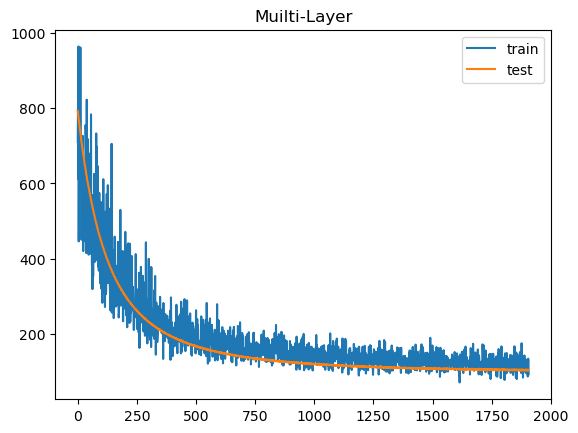

In [102]:
plt.plot(reskernel_trainloss[200:])
plt.plot(reskernel_testloss[200:])
plt.legend(['train','test'])
plt.title('Muilti-Layer')
plt.show()

In [103]:
#predict
x0=torch.from_numpy(test_x[:300].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    print(np.array(pred).reshape(-1))
    print(test_y[:300].to_numpy())
    bootbase=np.array(pred.reshape(-1))

[1989.3066 1992.3246 1999.8085 1994.339  1997.9138 1991.2365 1988.6501
 1987.2878 1988.4254 1992.5774 1992.654  2005.5607 2001.2927 2010.1442
 1999.0333 1989.6543 1990.1406 2002.2278 1996.6416 1993.3029 2012.7386
 1997.0756 2008.9181 2000.5    1998.5276 1995.2622 1991.2054 1996.1217
 1996.7806 1991.6248 1994.9125 1993.5481 1994.5743 1994.8406 1993.7935
 1994.383  2004.4104 1997.5583 1990.9059 1990.2933 2006.1443 1993.626
 2004.1525 2010.594  2002.8142 1997.8176 2000.4366 1999.1451 2003.652
 2006.4152 2012.7954 2009.062  1996.9634 1996.1755 2000.9672 1989.4573
 1989.1438 1991.4167 1990.6898 2005.8986 2005.8907 2006.0259 2005.5447
 2005.4877 1995.2412 2006.1803 2005.4877 2006.0452 2005.5568 2004.8025
 2006.8398 2001.3634 2001.3208 1993.5999 1993.4169 1991.3911 2005.2946
 1998.2715 1994.0583 1998.1387 2006.7297 1998.8646 1987.3627 1991.3796
 1991.2312 1987.3124 2000.7749 1989.9951 1988.1812 1984.619  1996.5454
 1987.7609 1996.5424 1997.5643 1995.6396 1991.0485 1995.2386 1997.8063
 1999.49

In [98]:
#predict
par=optimizer.param_groups[0]['params']

for i in range(len(train_x)):
    x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
print(Fi.shape)

temp=torch.linalg.pinv(Fi.T @ Fi)

length=[]
coverage=0
mark=0
for i in range(len(test_x)):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    #print(pred.detach().numpy()[0][0],test_y[i])
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    #print(2*1.96*np.sqrt(float(fFFf+1))) #approximate with df(infinity)
    
    if fFFf < 0:
        continue
    mark=mark+1
    length.append(2*1.96*np.sqrt(float(fFFf+1)))
    
    #coverage
    if pred.detach().numpy()[0][0]-1.96*np.sqrt(float(fFFf+1))<test_y[i] and pred.detach().numpy()[0][0]+1.96*np.sqrt(float(fFFf+1))>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark

print("n-p:",len(train_x)-f0.shape[0]," mark:",mark) 
print("length",np.mean(length))
print("95 coverage",coverage)


torch.Size([700, 489])
n-p: 211  mark: 300
length 4.031451683629943
95 coverage 0.12666666666666668


In [ ]:
#bootstrap  
boottime=80
bootlist=[]
for boot in tqdm(range(boottime)):
    alltrain=pd.concat([train_y,train_x],axis=1) 
    datachoose=resample(alltrain,replace=True)
    bootstrap_y=datachoose.iloc[:,0]
    bootstrap_x=datachoose.iloc[:,1:]
    bootstrap_x.reset_index(drop=True, inplace=True) 
    bootstrap_y.reset_index(drop=True, inplace=True) 
    nnbootstrap_x = torch.from_numpy(bootstrap_x.to_numpy()).float()
    nnbootstrap_y = torch.squeeze(torch.from_numpy(bootstrap_y.to_numpy()).float()) 
    nntest_x= torch.from_numpy(test_x.to_numpy()).float()
    nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())
    
    train_loader = DataLoader(mydataset(nnbootstrap_x, nnbootstrap_y),batch_size=100, shuffle=True)
    test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = ResKernelNet()
    net = net.to(device)
    torch.manual_seed(1)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=1e-7,momentum=0.9) #optim.Adam(...)
    reskernel_testloss=[]
    t0 = time.time()
    for epoch in range(2000): 
        for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
            x, y = x.to(device), y.to(device)
            # Compute prediction error
            y_pred = net(x)
            y_pred = torch.squeeze(y_pred)
            train_loss = criterion(y_pred, y)
            # Backpropagation
            optimizer.zero_grad() 
            train_loss.backward()
            optimizer.step()
        

        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
        
            test_loss = criterion(y_test_pred,y)
        
        if epoch>100 and float(test_loss)>max(reskernel_testloss[-100:-1]):
            break
        reskernel_testloss.append(float(test_loss))
    
            
    x0=torch.from_numpy(test_x[:300].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        bootlist.append(np.array(pred).reshape(-1))

In [27]:
np.array(bootlist).T
sorted_bootlist = [sorted(x)[:] for x in np.array(bootlist).T]
sorted_bootlist=np.array(sorted_bootlist)

lower=bootbase-(sorted_bootlist[:,77]-bootbase)
upper=bootbase-(sorted_bootlist[:,2]-bootbase)
print("confidence interval length",sorted_bootlist[:,77]-sorted_bootlist[:,2])
reskernelnet_length=(sorted_bootlist[:,77]-sorted_bootlist[:,2]).mean()
print("average confidence interval length",reskernelnet_length)

cover=0
for i in range(300):
    if lower[i]<=test_y[i] and upper[i]>=test_y[i]:
        cover=cover+1
reskernelnet_coverage=cover/300
print("95 coverage",reskernelnet_coverage)

confidence interval length [11.200806  11.182861  10.804321  20.100708  20.333374  10.38208
 10.414551  11.276978  27.766724  14.7751465 16.641357  13.123047
 18.319458  28.038208  15.685547  10.028076  20.826538   7.084961
  8.737793   8.089966  19.071655  24.241577  13.524658   8.488647
  9.511841   9.449951   8.826904   6.4852295  8.960205   6.9249268
 10.985474  10.597778   7.3444824  7.456543  12.689331   9.375488
  8.676392   9.789795  11.509888   9.844727  15.852173  13.272217
 14.291626  29.105469  19.030762  19.655273  21.906982   9.205811
 31.448242  59.357178  17.920166  15.793823  14.720703  31.570312
 15.713135  17.900146  14.180786  27.329468  17.6167    21.61316
 21.194336  22.770142  21.958496  22.34375   17.241333  25.936157
 22.34375   28.722534  19.710327  16.088501  12.526489  46.737915
 15.837769  10.668945  20.542847   8.550903  22.248535  29.267456
 22.592041  20.569092  17.262451  19.075684  18.504395  12.564575
 26.587769  18.30371   17.86499    9.057251   9.88

comparison

In [54]:
def plot_choose(fig,start,data):
    fig.plot(np.arange(start,len(data)),data[start:])

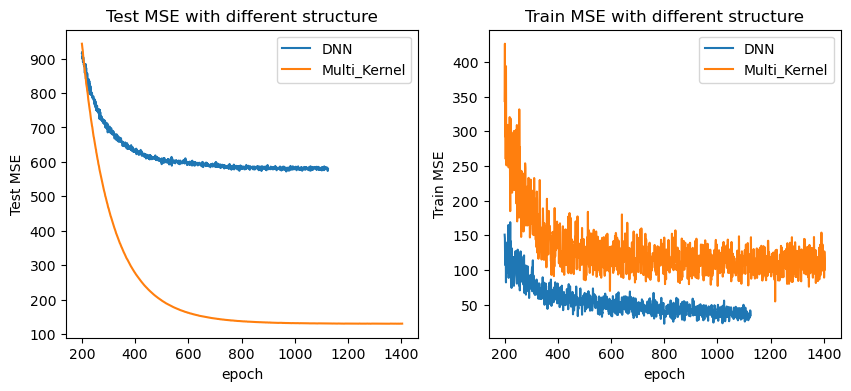

In [120]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_choose(ax[0],200,dnn_testloss)
plot_choose(ax[0],200,kernelnn_testloss)
ax[0].legend(["DNN","Multi_Kernel"])
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("Test MSE")
ax[0].set_title("Test MSE with different structure")

plot_choose(ax[1],200,dnn_trainloss)
plot_choose(ax[1],200,kernelnn_trainloss)
ax[1].legend(["DNN","Multi_Kernel"])
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("Train MSE")
ax[1].set_title("Train MSE with different structure")
plt.show()

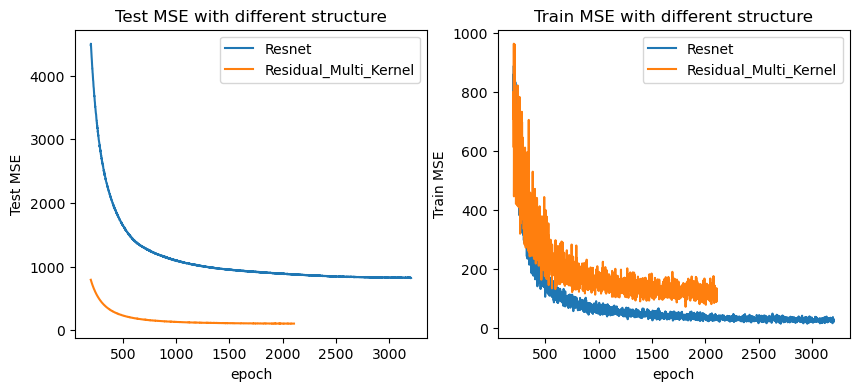

In [121]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_choose(ax[0],200,res_testloss)
plot_choose(ax[0],200,reskernel_testloss)
ax[0].legend(["Resnet","Residual_Multi_Kernel"])
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("Test MSE")
ax[0].set_title("Test MSE with different structure")

plot_choose(ax[1],200,res_trainloss)
plot_choose(ax[1],200,reskernel_trainloss)
ax[1].legend(["Resnet","Residual_Multi_Kernel"])
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("Train MSE")
ax[1].set_title("Train MSE with different structure")
plt.show()

In [126]:
dnn_length=107.71   
resnet_length=108.98 
kernelnet_length=46.51
reskernelnet_length=15.49 
dnn_coverage=0.913333
resnet_coverage=0.91
kernelnet_coverage=0.81
reskernelnet_coverage=0.477

[107.71, 108.98, 46.51, 15.49] [9.133329999999999, 9.1, 8.100000000000001, 4.77]


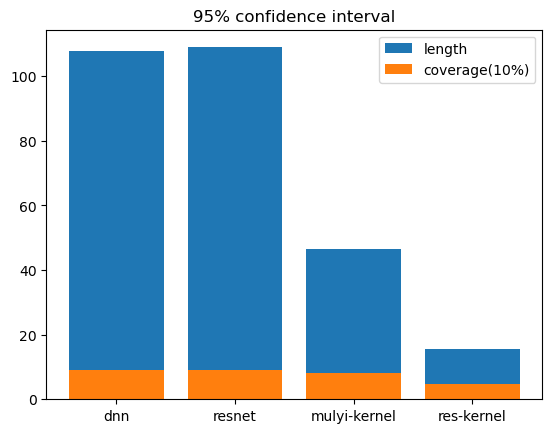

In [127]:
length=[dnn_length,resnet_length,kernelnet_length,reskernelnet_length]
coverage=[10*dnn_coverage,10*resnet_coverage,10*kernelnet_coverage,10*reskernelnet_coverage]
name=['dnn','resnet','mulyi-kernel','res-kernel']
print(length,coverage)
plt.bar(name,length)
plt.bar(name,coverage)
plt.legend(['length','coverage(10%)'])
plt.title("95% confidence interval")
plt.show()

## 3+. multi-layer learning (data splitting) 

In [456]:
#multi
#shuffle+dropout+prune
split=2
layer=2
length=int(len(train_x)/layer)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(32, 8)
        self.drop1=nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(8, 1)
        
    def forward(self, x):
        rff=RandomFourierFeature(90,32,kernel='C',gamma=0.01)
        y=x.detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        x=self.fc1(x)
        x = self.drop1(x)
        rff=RandomFourierFeature(8,8,kernel='G',gamma=0.1)
        y=x.detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        return self.fc2(x)


#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)

np.random.seed(0)
row_rand_array = np.arange(train_x.shape[0])
np.random.shuffle(row_rand_array)

train_loaderset=[] # there are "split" elements
netset=[]
optimizerset=[]
train_loss=[]
test_loss=[]

for i in range(split):
    if i==0:
        train_loaderset1=[]
        for l in range(layer): #split into different dataset
            curx=pd.DataFrame(train_x.values[row_rand_array[l*length:(l+1)*length]])
            cury=pd.DataFrame(train_y.values[row_rand_array[l*length:(l+1)*length]])
            nnx = torch.from_numpy(curx.to_numpy()).float()
            nny = torch.squeeze(torch.from_numpy(cury.to_numpy()).float()) 
            train_loader = DataLoader(mydataset(nnx, nny),batch_size=100, shuffle=True)
            train_loaderset1.append(train_loader)
    else:
        temp=train_loaderset1[0]
        train_loaderset1.remove(temp)
        train_loaderset1.append(temp)
    train_loaderset.append(train_loaderset1)

    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = KernelNet()
    net = net.to(device)
    torch.manual_seed(1)
    net.apply(init_weights)
    netset.append(net)      
   
    optimizer1=[]
    optimizer1.append(optim.SGD([{'params': net.fc1.parameters()}],lr=1e-4,momentum=0.9) )
    optimizer1.append(optim.SGD([{'params': net.fc2.parameters()}],lr=1e-4,momentum=0.9) )
    optimizerset.append(optimizer1)
    
    train_loss.append(0)
    test_loss.append(0)
    
criterion=nn.MSELoss()    
loss=[]
splkernel_trainloss=[]
splkernel_testloss=[]
t0 = time.time()
for epoch in range(2000): 
    for i in range(split):
    
        for l in range(layer):
            for x, y in train_loaderset[i][l]: #for batch, (x, y) in enumerate(train_loader): 
                # Data Splitting
                # every step, update a layer with smaller dataset 
                x, y = x.to(device), y.to(device)
                # Compute prediction error
                y_pred = netset[i](x)
                y_pred = torch.squeeze(y_pred)
                train_loss[i] = criterion(y_pred, y)
                
                # Backpropagation
                optimizerset[i][l].zero_grad() 
                train_loss[i].backward()
                optimizerset[i][l].step()
            
    if epoch % 100 == 0: 
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            for i in range(split):
                y_test_pred = netset[i](x)
                y_test_pred = torch.squeeze(y_test_pred)
            
                test_loss[i] = criterion(y_test_pred,y)
        print(f'''epoch {epoch}
            Train set - loss: {sum(train_loss)/len(train_loss)}
            Test  set - loss: {sum(test_loss)/len(test_loss)}
            ''')
    splkernel_trainloss.append(float(sum(train_loss)/len(train_loss)))
    splkernel_testloss.append(float(sum(test_loss)/len(test_loss)))
            
        
dnn_fit = time.time() - t0
print("KernelNet(data splitting) complexity and model fitted in %.3f s" % dnn_fit)

epoch 0
            Train set - loss: 3977064.5
            Test  set - loss: 3989863.0
            
epoch 100
            Train set - loss: 803440.75
            Test  set - loss: 807925.5
            
epoch 200
            Train set - loss: 160320.921875
            Test  set - loss: 166553.40625
            
epoch 300
            Train set - loss: 27920.076171875
            Test  set - loss: 27990.8203125
            
epoch 400
            Train set - loss: 7762.96142578125
            Test  set - loss: 6146.40966796875
            
epoch 500
            Train set - loss: 2516.0439453125
            Test  set - loss: 2510.4072265625
            
epoch 600
            Train set - loss: 357.90472412109375
            Test  set - loss: 102.1432113647461
            
epoch 700
            Train set - loss: 243.6397705078125
            Test  set - loss: 256.8683776855469
            
epoch 800
            Train set - loss: 163.70550537109375
            Test  set - loss: 175.7274322509

In [457]:
print(y_test_pred,y)

tensor([1993.3323, 1993.1406, 1993.3235, 1992.6833, 1993.5430, 1992.9119,
        1993.0767, 1993.2113, 1993.9171, 1993.9015, 1994.2769, 1992.8699,
        1993.2947, 1993.1624, 1993.0315, 1993.2756, 1993.6322, 1993.8663,
        1992.7780, 1993.1962, 1993.2377, 1993.0142, 1992.7167, 1993.5446,
        1992.5745, 1993.7064, 1994.4347, 1993.0640, 1993.0807, 1994.4701,
        1993.1069, 1993.1110, 1992.8370, 1993.4972, 1993.4125, 1993.1665,
        1992.8292, 1992.9645, 1993.1979, 1993.0819, 1993.9406, 1993.5681,
        1992.9841, 1993.3712, 1993.0863, 1993.0135, 1993.1525, 1993.0634,
        1992.9434, 1993.2635, 1993.6561, 1993.4227, 1992.9148, 1993.3561,
        1993.0322, 1993.1300, 1992.9895, 1993.0680, 1992.8889, 1992.6072,
        1993.5034, 1993.1498, 1993.0740, 1992.8915, 1993.0391, 1993.9200,
        1993.4722, 1992.9011, 1993.1675, 1992.7607, 1992.5386, 1993.5598,
        1993.0801, 1993.1887, 1993.0494, 1992.7500, 1993.0646, 1992.8691,
        1993.6022, 1992.9271, 1993.280

## 4+. residual learning (data splitting) 

In [12]:
#shuffle+dropout+prune
split=3
layer=3
length=int(len(train_x)/layer)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures,kernel,gamma):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.kernel=kernel
        self.gamma=gamma  
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(outfeatures,outfeatures)
    
    def forward(self, x):
        rff=RandomFourierFeature(self.infeatures,self.outfeatures,kernel=self.kernel,gamma=self.gamma)
        y=x.detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        y = torch.from_numpy(yn).float()
        x = self.fc1(x)
        y = self.fc2(y)
        return x+y

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(90,32,"C",0.01)
        self.rblock2 = ResidualBlock(32,8,"G",0.01)
        self.fc3 = nn.Linear(8, 1)
 
    def forward(self, x):
        x = self.rblock1(x)
        x = self.rblock2(x)
        return self.fc3(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)

np.random.seed(0)
row_rand_array = np.arange(train_x.shape[0])
np.random.shuffle(row_rand_array)

train_loaderset=[] # there are "split" elements
netset=[]
optimizerset=[]
train_loss=[]
test_loss=[]

for i in range(split):
    if i==0:
        train_loaderset1=[]
        for l in range(layer): #split into different dataset
            curx=pd.DataFrame(train_x.values[row_rand_array[l*length:(l+1)*length]])
            cury=pd.DataFrame(train_y.values[row_rand_array[l*length:(l+1)*length]])
            nnx = torch.from_numpy(curx.to_numpy()).float()
            nny = torch.squeeze(torch.from_numpy(cury.to_numpy()).float()) 
            train_loader = DataLoader(mydataset(nnx, nny),batch_size=100, shuffle=True)
            train_loaderset1.append(train_loader)
    else:
        temp=train_loaderset1[0]
        train_loaderset1.remove(temp)
        train_loaderset1.append(temp)
    train_loaderset.append(train_loaderset1)

    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = ResKernelNet()
    net = net.to(device)
    torch.manual_seed(1)
    net.apply(init_weights)
    netset.append(net)      
   
    optimizer1=[]
    optimizer1.append(optim.SGD([{'params': net.rblock1.parameters()}],lr=1e-7,momentum=0.9) )
    optimizer1.append(optim.SGD([{'params': net.rblock2.parameters()}],lr=1e-7,momentum=0.9) )
    optimizer1.append(optim.SGD([{'params': net.fc3.parameters()}],lr=1e-7,momentum=0.9) )
    optimizerset.append(optimizer1)
    
    train_loss.append(0)
    test_loss.append(0)
    
criterion=nn.MSELoss()    
loss=[]
splreskernel_trainloss=[]
splreskernel_testloss=[]
t0 = time.time()
for epoch in range(2000): 
    for i in range(split):
    
        for l in range(layer):
            for x, y in train_loaderset[i][l]: #for batch, (x, y) in enumerate(train_loader): 
                # Data Splitting
                # every step, update a layer with smaller dataset 
                x, y = x.to(device), y.to(device)
                # Compute prediction error
                y_pred = netset[i](x)
                y_pred = torch.squeeze(y_pred)
                train_loss[i] = criterion(y_pred, y)
                
                # Backpropagation
                optimizerset[i][l].zero_grad() 
                train_loss[i].backward()
                optimizerset[i][l].step()
            
    if epoch % 100 == 0: 
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            for i in range(split):
                y_test_pred = netset[i](x)
                y_test_pred = torch.squeeze(y_test_pred)
            
                test_loss[i] = criterion(y_test_pred,y)
        print(f'''epoch {epoch}
            Train set - loss: {sum(train_loss)/len(train_loss)}
            Test  set - loss: {sum(test_loss)/len(test_loss)}
            ''')
    splreskernel_trainloss.append(float(sum(train_loss)/len(train_loss)))
    splreskernel_testloss.append(float(sum(test_loss)/len(test_loss)))
            
        
dnn_fit = time.time() - t0
print("ResKernelNet(data splitting) complexity and model fitted in %.3f s" % dnn_fit)

epoch 0
            Train set - loss: 3884230.75
            Test  set - loss: 4538208.0
            
epoch 100
            Train set - loss: 37308.28515625
            Test  set - loss: 41714.97265625
            
epoch 200
            Train set - loss: 7066.82568359375
            Test  set - loss: 11622.3232421875
            
epoch 300
            Train set - loss: 2566.609619140625
            Test  set - loss: 3781.7412109375
            
epoch 400
            Train set - loss: 2001.03515625
            Test  set - loss: 2251.870849609375
            
epoch 500
            Train set - loss: 1239.6982421875
            Test  set - loss: 997.61669921875
            
epoch 600
            Train set - loss: 668.735107421875
            Test  set - loss: 655.0106811523438
            
epoch 700
            Train set - loss: 677.3681640625
            Test  set - loss: 683.1459350585938
            
epoch 800
            Train set - loss: 623.6839599609375
            Test  set - loss:

In [13]:
print(y_test_pred,y)

tensor([2002.7423, 1969.4929, 1998.1019, 2014.0671, 2000.7595, 1989.7957,
        2001.1283, 1994.5964, 1997.6364, 2002.7284, 2000.3146, 1991.9557,
        1993.4747, 1983.0541, 2008.8751, 1996.7327, 2003.2792, 2009.0494,
        2009.8417, 2011.3170, 1996.7909, 2005.3835, 2023.4139, 2008.1764,
        2000.8274, 1993.6996, 2018.3378, 2000.8590, 1988.6063, 2016.6719,
        1993.1942, 2022.1733, 2030.8192, 2026.1978, 2016.1039, 2011.8005,
        2013.9176, 2011.5963, 2014.0375, 2002.6067, 2020.1351, 1993.8763,
        2011.6370, 1996.5538, 1996.4169, 1996.5973, 2000.3690, 1996.9921,
        1994.5358, 2018.0647, 2008.5068, 1990.0903, 2005.9181, 1989.7269,
        2015.0759, 1992.1282, 2000.2751, 2006.6891, 2015.0726, 2002.4218,
        1995.3351, 1993.7534, 2011.7301, 1991.7052, 1997.6401, 1976.2909,
        1995.2758, 1998.0228, 2009.9363, 1972.1541, 1994.2573, 1995.0300,
        1971.1116, 1981.6732, 1994.5195, 1981.0101, 2003.3507, 2003.2255,
        1994.1180, 1980.7985, 1992.753

--------------------

prune

In [ ]:
parameters_to_prune = (
    (net.fc1, 'weight'),
    (net.rblock1.fc1, 'weight'),
    (net.rblock1.fc2, 'weight'),
    (net.fc2, 'weight'),
    (net.rblock2.fc1, 'weight'),
    (net.rblock2.fc2, 'weight'),
    (net.fc3, 'weight'),
    (net.rblock3.fc1, 'weight'),
    (net.rblock3.fc2, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
)

print(
    "Sparsity in net.fc1.weight: {:.2f}%".format(
        100. * float(torch.sum(net.fc1.weight == 0))
        / float(net.fc1.weight.nelement())
    )
)
print(
    "Sparsity in net.fc2.weight: {:.2f}%".format(
        100. * float(torch.sum(net.fc2.weight == 0))
        / float(net.fc2.weight.nelement())
    )
)
print(
    "Sparsity in net.fc3.weight: {:.2f}%".format(
        100. * float(torch.sum(net.fc3.weight == 0))
        / float(net.fc3.weight.nelement())
    )
)

print(
    "Sparsity in net.rblock1.fc1.weight: {:.2f}%".format(
        100. * float(torch.sum(net.rblock1.fc1.weight == 0))
        / float(net.fc1.weight.nelement())
    )
)
print(
    "Sparsity in net.rblock1.fc2.weight: {:.2f}%".format(
        100. * float(torch.sum(net.rblock1.fc2.weight == 0))
        / float(net.fc2.weight.nelement())
    )
)
print(
    "Sparsity in net.rblock2.fc1.weight: {:.2f}%".format(
        100. * float(torch.sum(net.rblock1.fc1.weight == 0))
        / float(net.fc1.weight.nelement())
    )
)
print(
    "Sparsity in net.rblock2.fc2.weight: {:.2f}%".format(
        100. * float(torch.sum(net.rblock1.fc2.weight == 0))
        / float(net.fc2.weight.nelement())
    )
)
print(
    "Sparsity in net.rblock3.fc1.weight: {:.2f}%".format(
        100. * float(torch.sum(net.rblock1.fc1.weight == 0))
        / float(net.fc1.weight.nelement())
    )
)
print(
    "Sparsity in net.rblock3.fc2.weight: {:.2f}%".format(
        100. * float(torch.sum(net.rblock1.fc2.weight == 0))
        / float(net.fc2.weight.nelement())
    )
)

prune.remove(net.fc1, 'weight')
prune.remove(net.rblock1.fc1, 'weight')
prune.remove(net.rblock1.fc2, 'weight')
prune.remove(net.fc2, 'weight')
prune.remove(net.rblock2.fc1, 'weight')
prune.remove(net.rblock2.fc2, 'weight')
prune.remove(net.fc3, 'weight')
prune.remove(net.rblock3.fc1, 'weight')
prune.remove(net.rblock3.fc2, 'weight')
for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    y_test_pred = net(x)
    y_test_pred = torch.squeeze(y_test_pred)
        
    test_loss = criterion(y_test_pred,y)
print(f'''epoch {epoch}
        Train set - loss: {train_loss}
        Test  set - loss: {test_loss}
        ''')